# 16ML Week 6: Hierarchical Clustering

In this assignment, we will explore the theory and application of *hierarchical clustering*, a clustering algorithm that splits or joins clusters based on a flexible cluster similarlity metric until a stopping condition is satisfied.

## Algorithm Overview

Hierarchical clustering creates a tree-like structure that allows you to assign a data point to a cluster. The tree can be created from the bottom up, or from the top down. Each of these methods corresponds to a variant of hierarchical clustering; aptly named *agglomerative* and *divisive* clustering, respectively. When using the bottom-up approach, the algorithm starts with each data point in its own cluster, and successively merges the closest two clusters into one cluster until it has reached the desired number of clusters. The top-down approach does the reverse: it splits each cluster into two until the cluster can no longer be divided.

In the remainder of this problem set, we will
1. observe a demo of hierarchical clustering
2. implement each variant of hirarchical clustering, and compare the two
3. develop an intution for setting hyperparameters using sklearn's [AgglomerativeClustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) or scipy's [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) function.
4. apply hierarchical clustering on real world problem settings

# Part 1: Demo

In this section, we'll look at some example datasets and how K-Means and hierarchical clustering perform to gain an intution for the strengths and weaknesses of each algorithm.

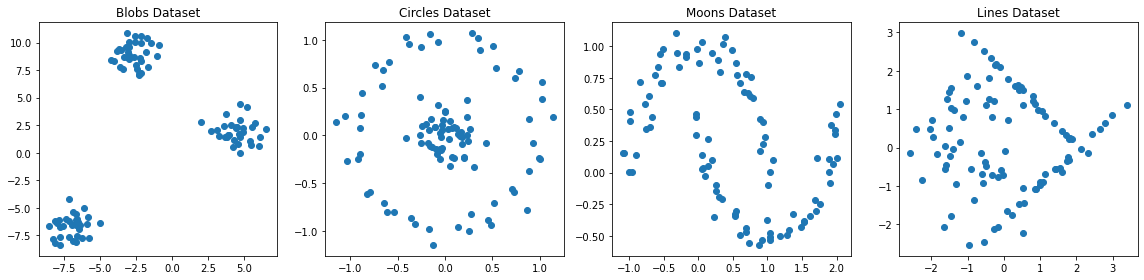

In [2]:
#@title Sample datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles, make_classification, make_moons

COLORS = np.array(sns.color_palette())

class Dataset:
  def __init__(self, data, title, n_clusters):
    self.data = data
    self.data.flags.writeable = False
    self.title = title
    self.n_clusters = n_clusters

  @property
  def x(self):
    return self.data[:, 0]

  @property
  def y(self):
    return self.data[:, 1]

  def plot(self, axis, coloraxis=None):
    axis.scatter(self.x, self.y, c=coloraxis)
    axis.set_title(f'{self.title} Dataset')

  def plot_clusters(self, clusterer, axis):
    pred_clusters = clusterer.fit_predict(self.data)
    self.plot(axis, coloraxis=COLORS[pred_clusters])
    

blobs_dataset = Dataset(make_blobs(centers=3, random_state=42)[0], 'Blobs', 3)
circles_dataset = Dataset(make_circles(noise=0.09, factor=.2, random_state=42)[0], 'Circles', 2)
lines_dataset = Dataset(make_classification(n_features=2, n_redundant=0, random_state=4242)[0], 'Lines', 3)
moons_dataset = Dataset(make_moons(noise=0.07)[0], 'Moons', 2)

datasets = [
  blobs_dataset,
  circles_dataset,
  moons_dataset,
  lines_dataset,
]

def plt_datasets(datasets, title=None, plotter=Dataset.plot):
  fig, axes = plt.subplots(nrows=1,
                           ncols=len(datasets),
                           figsize=(4*len(datasets), 4))
  for (dataset, axis) in zip(datasets, axes):
    plotter(dataset, axis)
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()

plt_datasets(datasets)

## K-Means

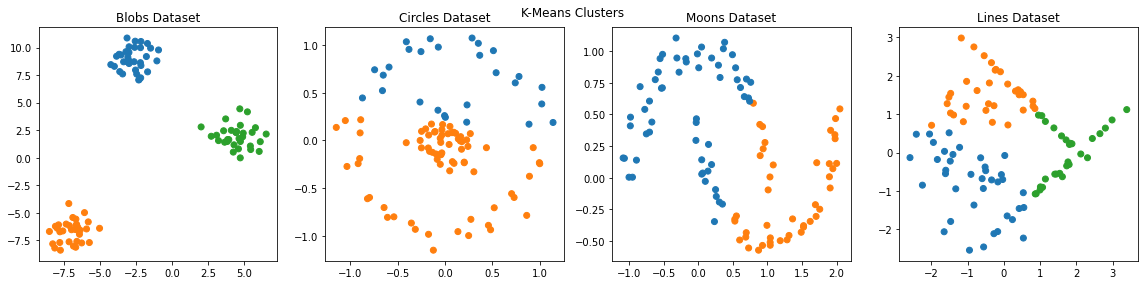

In [3]:
#@title K-Means Clusters
from sklearn.cluster import KMeans
plt_datasets(datasets,
             title='K-Means Clusters',
             plotter=lambda dataset, axis: dataset.plot_clusters(
                 KMeans(n_clusters=dataset.n_clusters), axis))

As we may expect, K-Means works well when its assumptions are followed.The clusters are well separated blobs in Euclidean space. However, that only applies to the first dataset.

For the second _Circles_ dataset, you could consider using the kernel K-Means algorithm that you designed on the previous homework, but the _Moons_ and _Lines_ datasets would require challening kernel functions. What if we could use a different algorithm entirely? How about heirarchical clustering?

## Hierarchical Clustering

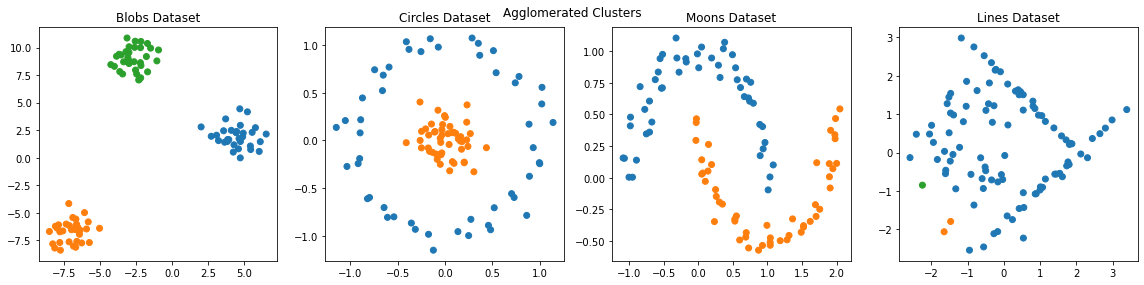

In [4]:
#@title Heirarchical Clustering Clusters
from sklearn.cluster import AgglomerativeClustering
plt_datasets(datasets,
             title='Agglomerated Clusters',
             plotter=lambda dataset, axis: dataset.plot_clusters(
                 AgglomerativeClustering(linkage='single', n_clusters=dataset.n_clusters),
                 axis))

Ah, much better. The second and third datasets' clustering results are looking pretty good! The fourth one, not so much, but we'll work on that one later.

Let's focus in on the details of the second plot to gain an intiution for the algorithm. It'll come in handy when you implement hierarchical clustering in the following sections.

Recall that agglomerative clustering successively merges the two "nearest" clusters until the desired number of clusters remain. The following cell plots the algorithm's progress as five clusters are merged into the final two, as well as the resulting *dendrogram*.

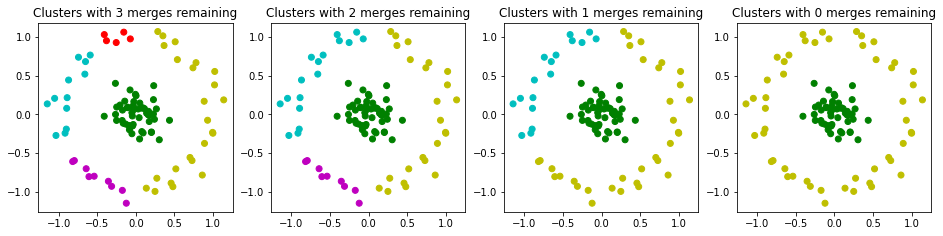

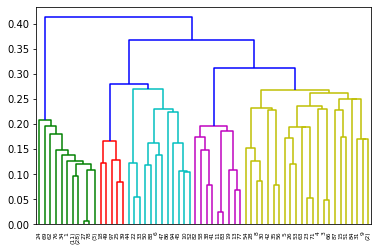

In [5]:
#@title Agglomerative clusters
import numpy as np
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

def calc_linkage_matrix(clusterer):
    counts = np.zeros(clusterer.children_.shape[0])
    n_samples = len(clusterer.labels_)
    for i, merge in enumerate(clusterer.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [clusterer.children_,  clusterer.distances_, counts]).astype(float)

clusterer = AgglomerativeClustering(distance_threshold=0.4, n_clusters=None, linkage='single')
clusterer.fit(circles_dataset.data)

linkage = calc_linkage_matrix(clusterer)

trees = hierarchy.cut_tree(linkage, n_clusters=list(range(5, 1, -1)))

nrows = 1
ncols = trees.shape[1] // nrows
fig, axes = plt.subplots(nrows=1,
                         ncols=trees.shape[1],
                         figsize=(4*trees.shape[1], 4))

DENDROGRAM_COLORS = np.array(['g', 'y', 'c', 'm', 'r'])
            
for i in range(trees.shape[1]):
  ax = axes[i]
  ax.set_aspect('equal')
  ax.scatter(circles_dataset.x, circles_dataset.y, c=DENDROGRAM_COLORS[trees[:, i]])
  ax.set_title(f'Clusters with {trees.shape[1] - i - 1} merges remaining')
plt.show()

hierarchy.dendrogram(linkage, truncate_mode='level', p=8, color_threshold=.28);

We see that the central circle is well classified early on: even with 3 merges remaining, the subtree in the dendrogram (green) requires no further merges. However, the outer circle, due to noise and sparsity has three extra clusters.

The first of the outer ring's clusters to be merged are red and cyan, which happens because they are the two clusters with points closest together (for some definition of _close_, which we will explore later). Next, yellow and magenta are merged, as we see as the third highest node in the dendrogram. Finally, the (merged) cyan and (merged) yellow clusters are merged, leaving us with the two clusters that we so greatly desire.

# Part 2: Implement Hierarchical Clustering

In this section, you will have the chance to implement both agglomerative and divisive clustering with the given interface. After finishing the implementation, you can verify the correctness of your implementation via the interative demo and compare the result with sklearn implementation. 

In [6]:
# we first import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from typing import Dict, Set

For simplicity, we assume the given data is of 2 dimensional. We provide the following interface to you. Fill in the blanks. 

In [7]:
class Cluster:
    '''
	Class which defines a single cluster
	'''
    def __init__(self, cluster_id: int, data_indexes: Set[int]):
        '''
        Initialize the cluster with unique cluster id and corresponding data currently contained in the cluster
        '''
        self.id = cluster_id
        self.data_indexes = data_indexes
        self.min = (-1, np.inf)  # (id, dissimilarity)
    
    def merge(self, c: "Cluster"):
        '''
        Merges the data indexes in "c" into the current cluster
        '''
        ### Implementation Starts ###
        self.data_indexes = self.data_indexes.union(c.data_indexes)
        ### Implementation Ends ###

    def __len__(self):
        return len(self.data_indexes)


class Clustering:
    '''
	Class inherited by different hierarchical clustering methods
	'''
    def __init__(self, data: np.ndarray):
        '''
        Initialize with all data points and linkage function
        '''
        self.n_clusters = 0
        self.data = data
        self.n_data = data.shape[0]
        self.clusters: Dict[int, Cluster] = {}  # id: cluster
        self.dissimilarity_table = np.zeros((self.n_data, self.n_data))

    def add_cluster(self, cluster: Cluster):
        '''
        Add a new cluster object
        '''
        ### Implementation Starts ###
        assert cluster.id not in self.clusters
        self.n_clusters += 1
        self.clusters[cluster.id] = cluster
        ### Implementation Ends ###

    def remove_cluster(self, cluster_id: int):
        '''
        Remove a merged cluster
        '''
        ### Implementation Starts ###
        if cluster_id in self.clusters:
            del self.clusters[cluster_id]
            self.n_clusters -= 1
        ### Implementation Ends ###


Implement affinity function and four different types of linkage function below.

In [8]:
def affinity(x, y):
    '''
    Return the Eclidian distance between two data points x and y (here we assume they are both 2D vector)
    '''
    ### Implementation Starts ###
    return np.linalg.norm(x - y)
    ### Implementation Ends ###


def single_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the single linkage dissimilarity
    '''
    ### Implementation Starts ###
    min_dissimilarity = np.inf
    if c1.id == c2.id:
        return np.inf
    for d1 in c1.data_indexes:
        for d2 in c2.data_indexes:
            min_dissimilarity = min(affinity_func(c.data[d1], c.data[d2]), min_dissimilarity)
    return min_dissimilarity
    ### Implementation Ends ###


def complete_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the complete linkage dissimilarity
    '''
    ### Implementation Starts ###
    max_dissimilarity = -np.inf
    if c1.id == c2.id:
        return np.inf
    for d1 in c1.data_indexes:
        for d2 in c2.data_indexes:
            max_dissimilarity = max(affinity_func(c.data[d1], c.data[d2]), max_dissimilarity)
    return max_dissimilarity
    ### Implementation Ends ###


def average_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the average linkage dissimilarity
    '''
    ### Implementation Starts ###
    if c1.id == c2.id:
        return np.inf
    dissimilarity_sum = 0
    for d1 in c1.data_indexes:
        for d2 in c2.data_indexes:
            dissimilarity_sum += affinity_func(c.data[d1], c.data[d2])
    return dissimilarity_sum / len(c1) / len(c2)
    ### Implementation Ends ###


def ward_linkage(c: Clustering, c1: Cluster, c2: Cluster, affinity_func=affinity):
    '''
    Return the ward linkage dissimilarity
    '''
    ### Implementation Starts ###
    if c1.id == c2.id:
        return np.inf
    m1 = np.mean(c.data[list(c1.data_indexes), :], axis = 0)
    m2 = np.mean(c.data[list(c2.data_indexes), :], axis = 0)
    return affinity_func(m1, m2)**2 * len(c1) * len(c2) / (len(c1) + len(c2))
    ### Implementation Ends ###


## Impelmentation of Agglomerative Clustering

In [9]:
class AggClustering(Clustering):
    def __init__(self, data, linkage_func):
        super().__init__(data)
        '''
        Initialize agglomerative clustering with n separate clusters and initialize the dissimilarity_table and nearest neighbour of each cluster
        '''
        self.linkage = linkage_func
        ### Implementation Starts ###
        for i in range(self.n_data):
            self.add_cluster(Cluster(i, {i}))
        for i in self.clusters:
            for j in self.clusters:
                distance = self.linkage(self, self.clusters[i], self.clusters[j])
                self.dissimilarity_table[i, j] = distance
                if distance < self.clusters[i].min[1]:
                    self.clusters[i].min = (j, distance)
        ### Implementation Ends ###

    def find_minimum_pair(self):
        '''
        Find the pair of cluster with minimum dissimilarity
        ----
        Return: index of two clusters
        '''
        ### Implementation Starts ###
        min_pair = (-1, -1, np.inf)
        for i, cluster in self.clusters.items():
            if cluster.min[1] < min_pair[2]:
                min_pair = (i, cluster.min[0], cluster.min[1])
        return min_pair
        ### Implementation Ends ###

    def merge_update_cluster(self, target_id: int, victim_id: int):
        '''
        This function need to deal with three tasks
            1. Merge the cluster with id victim_id into the cluster with id target_id
            2. Update the dissimilarity with respect to victim cluster
            3. Update the closest neighbour
        '''
        ### Implementation Starts ###
        # Merge victim into target
        victim_cluster = self.clusters.pop(victim_id)
        target_cluster = self.clusters[target_id]
        target_cluster.merge(victim_cluster)
        self.n_clusters -= 1

        # remove dissimilarity values related with victim
        self.dissimilarity_table[victim_id, :] = np.inf
        self.dissimilarity_table[:, victim_id] = np.inf

        # update dissimilarity values and neighbours
        for i in self.clusters.keys():
            dissimilarity = self.linkage(self, self.clusters[i], target_cluster)
            self.dissimilarity_table[i, target_id] = dissimilarity
            self.dissimilarity_table[target_id, i] = dissimilarity
        for i in self.clusters.keys():
            min_idx = np.argmin(self.dissimilarity_table[i, :])
            self.clusters[i].min = (min_idx, self.dissimilarity_table[i, min_idx])
        ### Implementation Ends ###


In [10]:
# code for interactive demo; no implementation needed
def plot_clustering(dataset, assignments):
    for i, indexes in assignments.items():
        plt.scatter(dataset[list(indexes), 0], dataset[list(indexes), 1])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


def interact_clustering(dataset, logger):
    history = list(logger)

    def plotter(i):
        plot_clustering(dataset, history[i])

    interact(plotter, i=IntSlider(min=0, max=len(history) - 1, continuous_update=False))


In [11]:
def copy_cluster_assignments(clusters):
    assignments = {}
    for i, cluster in clusters.items():
        assignments[i] = cluster.data_indexes.copy()
    return assignments

def perform_agglomerative_clustering(n_cluster, dataset, linkage_func):
    clusters = AggClustering(dataset, linkage_func)
    while clusters.n_clusters > n_cluster:
        yield copy_cluster_assignments(clusters.clusters)
        ### Implementation Starts ###
        id1, id2, distance = clusters.find_minimum_pair()
        clusters.merge_update_cluster(id1, id2)
        ### Implementation Ends ###
    yield copy_cluster_assignments(clusters.clusters)

def final_agglomerative_clustering(n_cluster, dataset, linkage_func):
    out = list(perform_agglomerative_clustering(n_cluster, dataset, linkage_func))
    return out[-1]

After implementing all the functions above, we can enjoy the following interactive plot. Adjust *num* and *linkage_func* and compare different linkage functions.

In [12]:
num = 10
dataset = np.random.rand(num, 2)
interact_clustering(dataset, perform_agglomerative_clustering(1, dataset, single_linkage))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=9), Output()), _dom_cla…

If you find your implementation work correctly on the above toy examples, you can validate the implementation on larger cases by comparing with Sklearn's Agglomerative Clustering function below. Feel free to try out different number of clusters, linkage functions, etc.

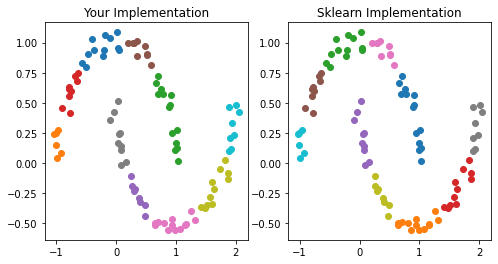

In [13]:
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering
# generate dataset
moons_dataset = Dataset(make_moons(noise=0.05)[0], 'Moons', 2)
dataset = np.vstack((moons_dataset.x, moons_dataset.y)).T

linkage_mapping = {'ward': ward_linkage, 'single': single_linkage, 'complete': complete_linkage, 'average': average_linkage}

def plot_and_compare(n_clusters, dataset, linkage="ward"):
    result = final_agglomerative_clustering(n_clusters, dataset, linkage_mapping[linkage])
    labels = AgglomerativeClustering(n_clusters = n_clusters, linkage = linkage).fit(dataset)

    def visualize_clusters(axis, data, labels, title):
        cluster_labels = set(labels)
        for i in cluster_labels:
            axis.scatter(data[labels == i][:, 0], data[labels == i][:, 1])
        axis.set(title=title)
    
    def plot_clustering(axis, dataset, assignments, title):
        for i, indexes in assignments.items():
            axis.scatter(dataset[list(indexes), 0], dataset[list(indexes), 1])
        axis.set(title=title)
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plot_clustering(ax1, dataset, result, "Your Implementation")
    visualize_clusters(ax2, dataset, labels.labels_, "Sklearn Implementation")
    fig.show()

plot_and_compare(n_clusters=10, dataset=dataset, linkage="average")

Congratulations, you have successfully finished this part.

## Impelmentation of Divisive Clustering

After finishing the agglomerative clustering, it is also a good practice to implement the divisive clustering. Divisive clustering is a more challenging task compared to the agglomerative one, so we will provide more information in the provided interface.

In [14]:
class DivisiveClustering(Clustering):
    def __init__(self, data):
        '''
        Initialize divisive clustering with 1 entire clusters and dissimilarity_table
        '''
        super().__init__(data)
        self.last_index = 2 * self.n_data
        self.add_cluster(Cluster(self.last_index, set(range(self.n_data))))
        temp_clusters = {}
        for i in range(self.n_data):
            temp_clusters[i] = Cluster(i, {i})
        for i in range(self.n_data):
            for j in range(self.n_data):
                distance = affinity(self.data[i], self.data[j])
                self.dissimilarity_table[i, j] = distance
        for i in range(self.n_data):
            self.dissimilarity_table[i, i] = 0

    def splinter(self):
        '''
        1. Find the cluster with largest diameter
        2. Find the splinter element (point inside the cluster with maximum average distance w.r.t others)
        ---
        Return: splinter element, max diameter cluster's id
        '''
        ### Implementation Starts ###
        # Find cluster with largest diameter
        max_diameter_cluster_id = -1
        max_diameter = -np.inf
        for id, cluster in self.clusters.items():
            if len(cluster) < 1:
                diameter = -1
            else:
                data_index_list = list(cluster.data_indexes)
                diameter = np.max(self.dissimilarity_table[np.ix_(data_index_list, data_index_list)])
            if diameter > max_diameter:
                max_diameter_cluster_id = id
                max_diameter = diameter

        max_diameter_cluster = self.clusters[max_diameter_cluster_id]

        # Find the splinter element
        splinter_element = -1
        max_avg_within_cluster_distance = -np.inf
        data_indexes = list(max_diameter_cluster.data_indexes)
        for pt in data_indexes:
            cluster_distance = np.sum(self.dissimilarity_table[np.ix_(data_indexes, [pt])])
            avg_within_cluster_distance = cluster_distance / (len(max_diameter_cluster) - 1)
            if avg_within_cluster_distance > max_avg_within_cluster_distance:
                splinter_element = pt
                max_avg_within_cluster_distance = avg_within_cluster_distance

        return splinter_element, max_diameter_cluster_id
        ### Implementation Ends ###

    def reassign(self, splinter_element, orig_cluster_key):
        '''
        1. Judge whether other data points inside the target cluster belongs to splinter group
        2. Split the cluster
        '''
        ### Implementation Starts ###
        # Create temp clusters
        temp_new_cluster = Cluster(0, {splinter_element})
        self.clusters[orig_cluster_key].data_indexes.remove(splinter_element)
        temp_orig_cluster = self.clusters[orig_cluster_key]

        # Remove orig cluster from cluster dict
        self.remove_cluster(orig_cluster_key)

        # Calculate distances
        data_indexes = list(temp_orig_cluster.data_indexes)
        within_cluster_dist = {pt: np.mean(self.dissimilarity_table[np.ix_(data_indexes, [pt])]) for pt in
                               data_indexes}
        dist_to_splinter = {pt: self.dissimilarity_table[pt, splinter_element] for pt in data_indexes}
        dist_diff = {pt: (within_cluster_dist[pt] - dist_to_splinter[pt]) for pt in
                     data_indexes}  # if +ve, move to splinter

        # Reassign points
        for pt in data_indexes:
            if dist_diff[pt] > 0 and len(temp_orig_cluster) > 2:
                temp_new_cluster.data_indexes.add(pt)
                temp_orig_cluster.data_indexes.remove(pt)

        # Add temp clusters to cluster dict
        if len(temp_orig_cluster) > 0:
            if len(temp_orig_cluster) == 1:
                temp_orig_cluster.id = list(temp_orig_cluster.data_indexes)[0]
            else:
                self.last_index -= 1
                temp_orig_cluster.id = self.last_index
            self.add_cluster(temp_orig_cluster)

        if len(temp_new_cluster) > 0:
            if len(temp_new_cluster) == 1:
                temp_new_cluster.id = list(temp_new_cluster.data_indexes)[0]
            else:
                self.last_index -= 1
                temp_new_cluster.id = self.last_index
            self.add_cluster(temp_new_cluster)
        ### Implementation Ends ###



In [15]:
def perform_divisive_clustering(n_cluster, dataset):
    clustering = DivisiveClustering(dataset)
    while clustering.n_clusters < n_cluster:
        yield copy_cluster_assignments(clustering.clusters)
        ### Implementation Starts ###
        splinter_element, orig_cluster_key = clustering.splinter()
        clustering.reassign(splinter_element, orig_cluster_key)
        ### Implementation Ends ###
    yield copy_cluster_assignments(clustering.clusters)

def final_agglomerative_clustering(n_cluster, dataset):
    out = list(perform_divisive_clustering(n_cluster, dataset))
    return out[-1]

In [16]:
num = 10
dataset = np.random.rand(num, 2)
interact_clustering(dataset, perform_divisive_clustering(8, dataset))

interactive(children=(IntSlider(value=0, continuous_update=False, description='i', max=7), Output()), _dom_cla…

# Part 3: Explore Agglomerative Clustering Hyperparameters

Now you have obtained a better understanding of how agglomerative and divisive clustering works, and you can also see that the time complexity of hierarchical clustering algorithms are quite high. In practical settings, you seldom need to implement the algorithm from scratch. Even when you do that, you will be able to realize a more efficient version of the algorithm with priority queue (a useful data structure that you will soon encounter in the following weeks of CS61B).   
In practical cases, you will use Sklearn [Agglomerative Clustering function](https://sklearn.cluster.AgglomerativeClustering) or scipy [linkage function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html). They can both perform agglomerative clustering, but each of them has its own advantage over the other.  Sklearn's AgglomerativeClustering is more convenient to directly visualize final clustering results, while scipy's linkage function is better at demostrating the dendrogram (the linkage process).  
In this sections, we will take advantage of sklearn's AgglomerativeClustering to demo various possibilities of setting hyperparameters.

## Tuning linkage function

In practical setting, when you wish to apply agglomerative clustering, you need to pick the most approperiate clustering function. As for Sklearn Agglomerative Clustering, choices are single linkage, complete linkage, average linkage, and ward linkage. Different linkage function will be useful for different types/shapes of clusters. For the toy examples, you need to decide for the most apprioriate linkage function, visualize the result, and explain your choice and the underlying reason.  

In [17]:
from sklearn.cluster import AgglomerativeClustering

In [18]:
def visualize_clusters(data, labels):
    cluster_labels = set(labels)
    for i in cluster_labels:
        plt.scatter(data[labels == i][:, 0], data[labels == i][:, 1])
    plt.gca().set_aspect('equal', adjustable='box')

Case 1:

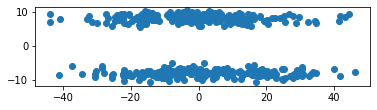

In [19]:
np.random.seed(101)
classA = np.random.randn(200, 2) * np.array([[16, 1]]) + np.array([[0, 8]])
classB = np.random.randn(200, 2) * np.array([[16, 1]]) + np.array([[0, -8]])
data = np.concatenate((classA, classB), axis = 0)
plt.scatter(data[:,0], data[:,1])
plt.gca().set_aspect('equal', adjustable='box')

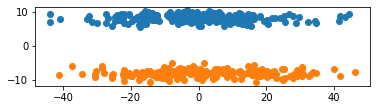

In [20]:
# Need choices from students
result = AgglomerativeClustering(n_clusters = 2, linkage = 'single').fit(data)
visualize_clusters(data, result.labels_)

Explanation Starts Here

Answer: Single linkage is the best choice here. Unlike average, ward, and complete linkage, the single linkage is local. It only considers the closest two points over two clusters, but ignore all other points of the cluster. It is good at clustering non-spherical or separated clusters. In the above elongated cluster case, single linkage can have the best performance.

Case 2:

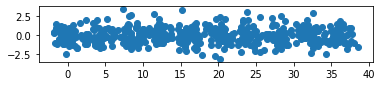

In [21]:
np.random.seed(100)
data = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), 50)
for i in range(1, 10):
    new_group = np.random.multivariate_normal(np.array([4 * i, 0]), np.array([[1, 0], [0, 1]]), 50)
    data = np.concatenate((data, new_group), axis = 0)
plt.scatter(data[:,0], data[:,1])
plt.gca().set_aspect('equal', adjustable='box');

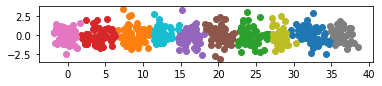

In [22]:
# Need students' answer here
result = AgglomerativeClustering(n_clusters = 10, linkage = 'ward').fit(data)
visualize_clusters(data, result.labels_)

Explanation Starts Here  
Answer: Complete, average, and ward linkage function are all suitable here, since all of them are good at clustering compact equal size clusters. 



Case 3:

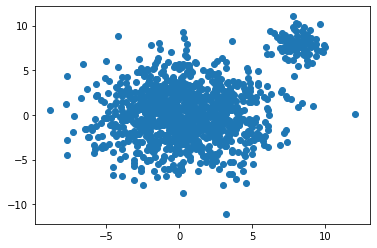

In [23]:
np.random.seed(101)
group1 = np.random.multivariate_normal(np.array([0, 0]), np.array([[8, 0], [0, 8]]), 1000)
group2 = np.random.multivariate_normal(np.array([8, 8]), np.array([[1, 0], [0, 1]]), 100)
data = np.concatenate((group1, group2), axis = 0)
plt.scatter(data[:,0], data[:,1]);

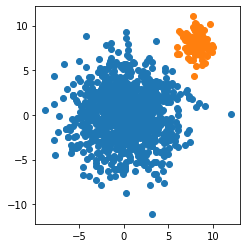

In [24]:
# Need students' answer here
result = AgglomerativeClustering(n_clusters = 2, linkage = 'ward').fit(data)
visualize_clusters(data, result.labels_)

Explanation Starts Here   
Answer: The most suitable choice is the ward linkage function. Ward linkage function tends to form compact clusters and minimize the variance inside the clusters.  
Complete linkage is not suitable here because as you can observe, it tends to form clusters with equal diameter. 

## Choose Appropriate Affinity Function



In many cases, the default Euclidean distance function is no longer appropriate in depicting the dissimilarity between two data points. For the following case, image that we wish to cluster the fan-shaped dataset into sectors. Explore different affinity metric to achieve the desired result. 

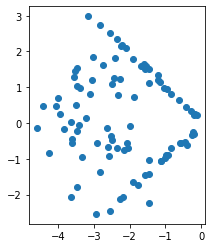

In [25]:
from sklearn.datasets import make_classification
lines_dataset = Dataset(make_classification(n_features=2, n_redundant=0, random_state=4242)[0], 'Lines', 3)
dataset = np.vstack((lines_dataset.x, lines_dataset.y)).T
dataset = dataset[dataset[:,0]<2] + [-2, 0]
plt.scatter(dataset[:,0], dataset[:,1])
plt.gca().set_aspect('equal', adjustable='box');

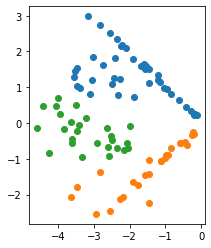

In [26]:
### Start your answer here ###
result = AgglomerativeClustering(n_clusters = 3, linkage = 'complete', affinity='cosine').fit(dataset)
visualize_clusters(dataset, result.labels_)

# Part 4: Practical Application

Finally, you will have the chance to apply clustering in some more practical settings.

## How Many Beacons? 

We start with a setting that you are already familiar with in ee16a lectures and labs. In APS lab, you are required to determine the distance between your receiver and different beacons. Now we change the setting by a little bit. You have collected a bunch of equal length signals, transmitted from an unknown number of beacons. Although you have no idea how each beacon signal looks like, you know that they are different and each received signal only contains one beacon pattern rather than contain an interleaving of multiple beacon patterns. Received signal from a beacon may be delayed by different timestamps and corrupted with noise.  
Load the `signals.pkl` dataset, ignore the `beacon` column which contains the correct labels, cluster the unlabelled signals using agglomerative clustering, and report the clustering result as well as number of different beacons.   
Guidelines:
You can follow the given steps to finish this problem.
- Load the dataset
- Apply Agglomerative Clustering with correct affinity function with scipy linkage function. (since signal vectors are all with high dimension, please wait for a few minutes for it to complete)
- Draw dendrogram to determine the number of clusters

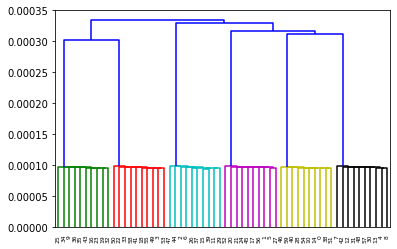

In [27]:
### Start Your Code Below ###
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Compute max correlation as the similarity of two signals
def max_signal_correlation(signal1, signal2):
    doubled_signal1 = np.concatenate((signal1,signal1))
    corr_vec = np.correlate(doubled_signal1, signal2, 'full')
    return np.max(corr_vec[len(signal2)-1: len(signal2)-1 + len(signal2)])

# Define the dissimilarity between two signals
def dissimilarity(x, y): 
    return 1 / max_signal_correlation(x, y)

# Load the dataset
signal = pd.read_pickle("signal.pkl")

# Clustering and draw dendrogram
Z = linkage(np.vstack(signal['Signal']), metric=dissimilarity)
dn = dendrogram(Z)

From the dendrogram, by cutting at the largest similarity gap, we can see that it has 6 clusters in total, which confirms with the ground truth. Then we check the correctness of our clustering result.

In [28]:
# gain the labels after deciding on the value of k
from sklearn.metrics import pairwise_distances
def signal_affinity(X):
    return pairwise_distances(X, metric=dissimilarity)

signal_labels = AgglomerativeClustering(n_clusters=6, affinity=signal_affinity, 
                                        linkage='average').fit(np.vstack(signal['Signal']))

In [29]:
# check whether clustering result confirms with ground truth
for i in range(5):
    assert len(set(signal.iloc[signal_labels.labels_ == i]['Beacon'])) == 1

## Cluster Analysis of Bike Sharing System

In this part, you will deal with real-life setting. You are given the citi-bike trip dataset, and we hope that you can perform some open-ended clustering analysis for bike stations according to trip patterns.   
The restrictions are:
- The objects for clustering are bike stations
- The analysis process/clustering criteria must involve user behavior or trip patterns. Simply use geographical distance to cluster stations is forbiddened
- You need to do some visualization to confirm your result (e.g. use folium map)

State the objective for you analysis here.  
Objective Starts Here  


This exercise do not have correct answer. So we just provide an example here. 
In this example, we aim to cluster bike stations into independent similar size clusters. We hope to minimize the number of trips across different clusters, so that each cluster can serve as a mini-system, in which operators can rebalance bikes or analyze total customer usage only inside the cluster.  

In [ ]:
import pandas as pd
import folium
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

trips = pd.read_csv('201701-citibike-tripdata.csv')

In [ ]:
trips = trips.drop(columns = ['Start Station Name', 'End Station Name', 'Bike ID', 'Birth Year', 'Gender'])

In [ ]:
trips.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Latitude,Start Station Longitude,End Station ID,End Station Latitude,End Station Longitude,User Type
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226,40.782750,-73.971370,3165,40.775794,-73.976206,Subscriber
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263,40.729236,-73.990868,498,40.748549,-73.988084,Subscriber
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143,40.776829,-73.963888,3152,40.768737,-73.961199,Customer
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143,40.776829,-73.963888,3152,40.768737,-73.961199,Customer
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143,40.776829,-73.963888,3152,40.768737,-73.961199,Customer


The entire travelling pattern may be chaotic and hard to be separated into several clusters, so we only pay attention to the travelling pattern in morning rush hours here. 

In [ ]:
trips['Start Time'] = pd.to_datetime(trips['Start Time'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
trips['Start Hour'] = trips['Start Time'].dt.hour
trips['Day'] = trips['Start Time'].dt.weekday

In [ ]:
morning_rush_hour_trips = trips[(trips['Start Hour'] >= 7) & (trips['Start Hour'] <= 9) &
                                (trips['Day'] <= 4)]

In [ ]:
inter_station_counts = morning_rush_hour_trips.groupby(['Start Station ID', 'End Station ID'])['Trip Duration'].count()
inter_station_counts = inter_station_counts.to_dict()

In [ ]:
# extract all stations
stations = trips[['Start Station ID', 'Start Station Latitude', 'Start Station Longitude']].rename(columns={
    'Start Station ID': 'Station ID', 'Start Station Latitude': 'Latitude', 'Start Station Longitude': 'Longitude'})
temp = trips[['End Station ID', 'End Station Latitude', 'End Station Longitude']].rename(columns={
    'End Station ID': 'Station ID', 'End Station Latitude': 'Latitude', 'End Station Longitude': 'Longitude'})
stations = pd.concat([stations, temp])
stations = stations.drop_duplicates(subset = ['Station ID']).reset_index(drop=True)

In [ ]:
stations = stations[(stations['Latitude']>40.65) & (stations['Latitude']<50)].set_index('Station ID')

Let's visualize station and inter-station trip tendencies.

In [ ]:
map = folium.Map(location=[40.7, -73.9], zoom_start=12)
for index, row in stations.iterrows():
    folium.Circle(row[['Latitude', 'Longitude']].tolist(), 
                  popup=str(int(index)), radius=0.1).add_to(map)
    for end_station, end_row in stations.iterrows():
        if end_station != index and ((index, end_station) in inter_station_counts or 
                                     (end_station, index) in inter_station_counts):
            count = 0
            if (index, end_station) in inter_station_counts:
                count += inter_station_counts[(index, end_station)]
            if (end_station, index) in inter_station_counts:
                count += inter_station_counts[(end_station, index)]
            if count > 30:
                points = [row[['Latitude', 'Longitude']].tolist(), end_row[['Latitude', 'Longitude']].tolist()]
                folium.PolyLine(points, color="red", weight=count/100, opacity=1).add_to(map)
map

From visualization, we can clearly see that two sides of the city separated by Hudson are clearly two clusters. Let's apply agglomerative clustering to do further analysis.

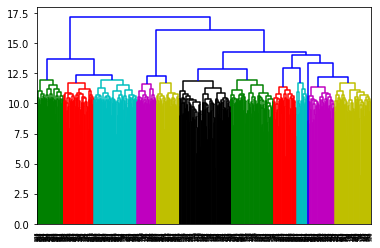

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
# Define the dissimilarity between two stations
# For any two stations, the dissimilarity is similar with the distance + alpha/inter_trip_count
def station_dissimilarity(x, y): 
    r = 6371
    id1, lat1, lon1 = x
    id2, lat2, lon2 = y
    lat1, lat2 = np.radians(lat1), np.radians(lat2)
    lon1, lon2 = np.radians(lon1), np.radians(lon2)
    a =  np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(lon1 - lon2)  
    c = np.arccos(a)      
    count = 0
    try:
         count += inter_station_counts[(int(id1), int(id2))]
         count += inter_station_counts[(int(id2), int(id1))] 
    except:
        pass
    return r*c + 10/np.exp(count/200) # Here we set alpha to 10 to emphasize the importance of trip counts

# Clustering and draw dendrogram
Z = linkage(np.vstack(stations.reset_index().to_numpy()), metric=station_dissimilarity, method='average')
dn = dendrogram(Z)

Cut at the maximum gap, we see that there will be 9 clusters. But as we can see, at that stage, there is still one "outlier" not merged into any cluster. After waiting that point to be merged, we will obtain 6 clusters, so we set k=6.

In [ ]:
from sklearn.metrics import pairwise_distances
def station_affinity(X):
    return pairwise_distances(X, metric=station_dissimilarity)

station_labels = AgglomerativeClustering(n_clusters=6, affinity=station_affinity, 
                                        linkage='average').fit(np.vstack(stations.reset_index().to_numpy()))
stations['label'] = station_labels.labels_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in arccos
  if sys.path[0] == '':


In [ ]:
map = folium.Map(location=[40.7, -73.9], zoom_start=12)
colmap = {0: 'black', 1: 'rosybrown', 2: 'blue', 3: 'red', 4: 'green', 
          5: 'blueviolet', 6: 'indigo', 7: 'orchid', 8: 'orange', 9: 'plum'}
for index, row in stations.iterrows():
    folium.Circle(row[['Latitude', 'Longitude']].tolist(), 
                  popup=str(int(index)), radius=0.1, color=colmap[row['label']]).add_to(map)
    for end_station, end_row in stations.iterrows():
        if end_station != index and ((index, end_station) in inter_station_counts or 
                                     (end_station, index) in inter_station_counts):
            count = 0
            if (index, end_station) in inter_station_counts:
                count += inter_station_counts[(index, end_station)]
            if (end_station, index) in inter_station_counts:
                count += inter_station_counts[(end_station, index)]
            if count > 30:
                points = [row[['Latitude', 'Longitude']].tolist(), end_row[['Latitude', 'Longitude']].tolist()]
                folium.PolyLine(points, color="lightgreen", weight=count/100, opacity=1).add_to(map)
map

Congratulations! You have finished this homework. Now you are familiar with hierarchy clustering and the corresponding applications. You will get to know more clustering algorithm in other topics of this week. 

# References:

Bikesharing dataset: https://www.kaggle.com/andytran11996/citibike-dataset-2017?select=201701-citibike-tripdata.csv  